## Using Temporal-Difference Learning

### Part 1: Implementation of Easy21

Same implementation as the previous algorithm

In [19]:
import random, numpy as np

In [20]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [21]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1]< 1 : # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, 0
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.


### Part 2: Sarsa($\lambda$) implementation

In [ ]:
def backward_view_sarsa_lambda():
    N = np.zeros((11, 22, 2, 11))
    V = np.zeros((11, 22, 2, 11))
    N0 = 100
    gamma = 1.0  

    number_of_episodes = 100000
    lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    for lambda_idx, lambda_val in enumerate(lambda_values):
        for episode in range(number_of_episodes):
            top_card = random.randint(1, 10)
            player_sum = random.randint(1, 10)
            s = (top_card, player_sum)
            a = 0 if random.random() < 0.5 else 1
            eligibility_trace = np.zeros((11, 22, 2))

            while True:
                s_new, r = step(s, a)

                if s_new[1] >= 1 and s_new[1] <= 21:
                    N[s_new[0], s_new[1], a, lambda_idx] += 1
                    epsilon_t = N0 / (N0 + N[s_new[0], s_new[1], a, lambda_idx])
                    a_new = np.argmax(V[s[0], s[1], :, lambda_idx]) if random.random() > epsilon_t else random.randint(0, 1)
                    alpha_t = 1 / N[s_new[0], s_new[1], a, lambda_idx]
                    delta = r + gamma * V[s_new[0], s_new[1], a_new, lambda_idx] - V[s[0], s[1], a, lambda_idx]
                    eligibility_trace[s[0], s[1], a] += 1

                    for i in range(11):
                        for j in range(22):
                            for k in range(2):
                                V[i, j, k, lambda_idx] += alpha_t * delta * eligibility_trace[i, j, k]
                                eligibility_trace[i, j, k] *= gamma * lambda_val

                    s = s_new
                    a = a_new

                if r != 0:
                    break

    return V

In [23]:
def q_t(episode_data, t, lambda_val, gamma, V, lambda_idx):
    T = len(episode_data)

    if t >= T:
        return 0

    if t == T - 1:
        return episode_data[t][2]

    q_t_return = 0
    max_n = T - t

    for n in range(1, max_n + 1):
        n_step_return = 0

        for k in range(n): # first term
            if t + k < T:
                n_step_return += (gamma ** k) * episode_data[t + k][2]

        if t + n < T: # second term
            state, action = episode_data[t + n][0], episode_data[t + n][1]
            if state[1] >= 1 and state[1] <= 21:
                n_step_return += (gamma ** n) * V[state[0], state[1], action, lambda_idx]

        if n == max_n:
            weight = lambda_val ** (n - 1)
        else:
            weight = (1 - lambda_val) * (lambda_val ** (n - 1))

        q_t_return += weight * n_step_return

    return q_t_return

In [24]:
# def forward_view_sarsa_lambda():
#     N = np.zeros((11, 22, 2, 11))

#     N0 = 100
#     gamma = 1.0

#     number_of_episodes = 100000
#     lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
#     V = np.zeros((11, 22, 2, 11))

#     for lambda_idx, lambda_val in enumerate(lambda_values):
#         for episode in range(number_of_episodes):
#             episode_data = []

#             top_card = random.randint(1, 10)
#             player_sum = random.randint(1, 10)
#             s = (top_card, player_sum)
#             a = 0 if random.random() < 0.5 else 1

#             while True:
#                 s_new, r = step(s, a)

#                 if s_new[1] >= 1 and s_new[1] <= 21:
#                     epsilon_t = N0 / (N0 + N[s_new[0], s_new[1], 0, lambda_idx] + N[s_new[0], s_new[1], 1, lambda_idx])
#                     a_new = np.argmax(V[s_new[0], s_new[1], :, lambda_idx]) if random.random() > epsilon_t else random.randint(0, 1)
#                     episode_data.append((s, a, r, s_new, a_new))

#                     s = s_new
#                     a = a_new
#                 else:
#                     episode_data.append((s, a, r, s_new, None))
#                     break

#                 if r != 0:
#                     break

#             for t in range(len(episode_data)):
#                 s_t, a_t, r_t, s_t_new, a_t_new = episode_data[t]

#                 N[s_t[0], s_t[1], a_t, lambda_idx] += 1
#                 alpha_t = 1 / N[s_t[0], s_t[1], a_t, lambda_idx]

#                 q_lambda_return = q_t(episode_data, t, lambda_val, gamma, V, lambda_idx)

#                 V[s_t[0], s_t[1], a_t, lambda_idx] += alpha_t * (q_lambda_return - V[s_t[0], s_t[1], a_t, lambda_idx])

#     return V


In [25]:
number_of_episodes = 100000

In [ ]:
def forward_view_sarsa_lambda():
    lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    number_of_episodes = 100000
    N = np.zeros((11, 22, 2, 11, number_of_episodes + 1))
    V = np.zeros((11, 22, 2, 11, number_of_episodes + 1))

    N0 = 100
    gamma = 1.0

    for lambda_idx, lambda_val in enumerate(lambda_values):
        for episode in range(number_of_episodes):
            episode_data = []

            top_card = random.randint(1, 10)
            player_sum = random.randint(1, 10)
            s = (top_card, player_sum)
            a = 0 if random.random() < 0.5 else 1

            while True:
                s_new, r = step(s, a)

                if s_new[1] >= 1 and s_new[1] <= 21:
                    epsilon_t = N0 / (N0 + N[s_new[0], s_new[1], 0, lambda_idx, episode] + N[s_new[0], s_new[1], 1, lambda_idx, episode])
                    a_new = np.argmax(V[s_new[0], s_new[1], :, lambda_idx, episode]) if random.random() > epsilon_t else random.randint(0, 1)
                    episode_data.append((s, a, r, s_new, a_new))

                    s = s_new
                    a = a_new
                else:
                    episode_data.append((s, a, r, s_new, None))
                    break

                if r != 0:
                    break

            V[:, :, :, lambda_idx, episode + 1] = V[:, :, :, lambda_idx, episode]
            N[:, :, :, lambda_idx, episode + 1] = N[:, :, :, lambda_idx, episode]

            for t in range(len(episode_data)):
                s_t, a_t, r_t, s_t_new, a_t_new = episode_data[t]

                N[s_t[0], s_t[1], a_t, lambda_idx, episode + 1] += 1
                alpha_t = 1 / N[s_t[0], s_t[1], a_t, lambda_idx, episode + 1]

                q_lambda_return = q_t(episode_data, t, lambda_val, gamma, V[:, :, :, :, episode], lambda_idx)

                V[s_t[0], s_t[1], a_t, lambda_idx, episode + 1] += alpha_t * (q_lambda_return - V[s_t[0], s_t[1], a_t, lambda_idx, episode + 1])

    return V


### Part 3: Plotting the value function and optimal policy

#### Backward View

In [27]:
import matplotlib.pyplot as plt

In [28]:
V = backward_view_sarsa_lambda()

KeyboardInterrupt: 

In [30]:
def plot_for_lambda(l, V):
    l = int(l * 10)
    Z_0 = np.transpose(V[:, :, 0, l])
    Z_1 = np.transpose(V[:, :, 1, l])
    Z = np.maximum(Z_0, Z_1)
    Z_diff = Z_1 - Z_0
    optimal_policy = np.argmax(V[:, :, :, l], axis=2)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
    ax.plot_surface(X, Y, Z_0, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Hit Action')
    ax.set_title('Value Function for Easy21 - Hit Action')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_1, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Stick Action')
    ax.set_title('Value Function for Easy21 - Stick Action')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Optimal Action')
    ax.set_title('Optimal Value Function for Easy21')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_diff, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Difference in Action Values')
    ax.set_title('Difference in Value Function for Easy21')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
    plt.colorbar(label='Action (0: Hit, 1: Stick)')
    plt.xlabel('Dealer Top Card')
    plt.ylabel('Player Total Value')
    plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
    plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
    plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
    plt.show()

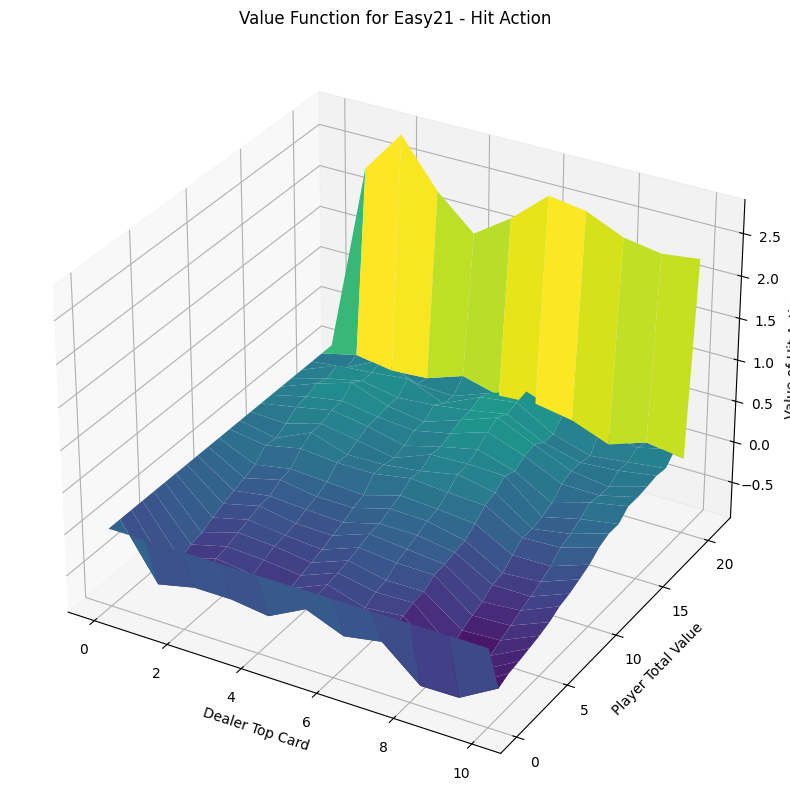

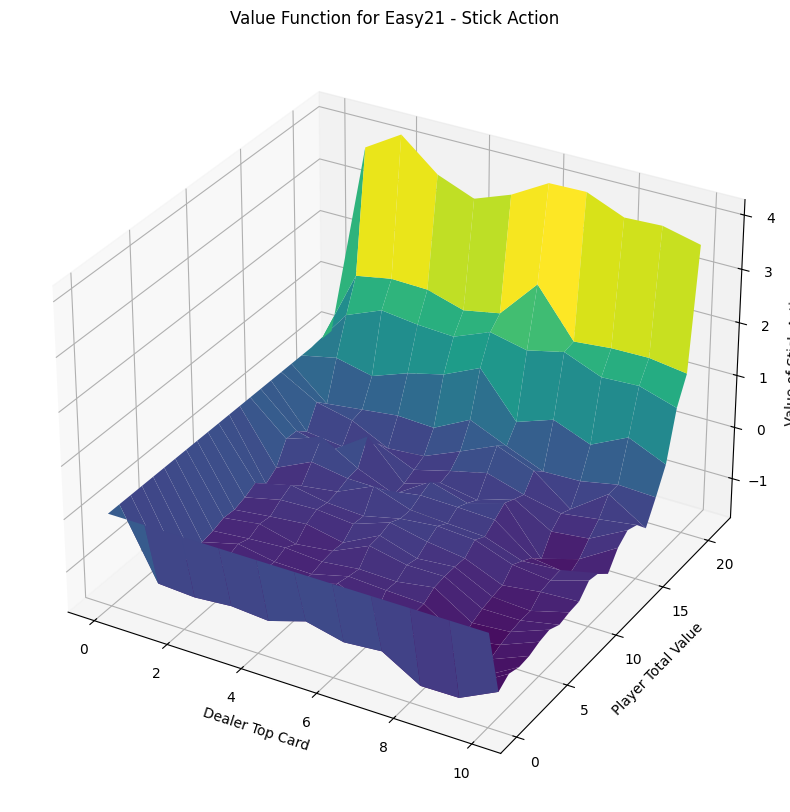

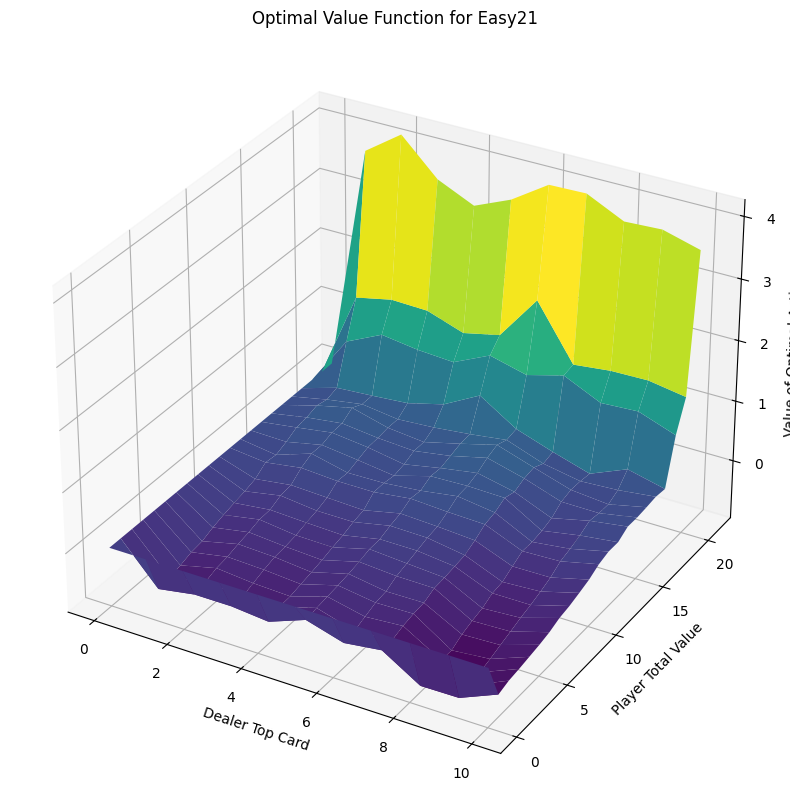

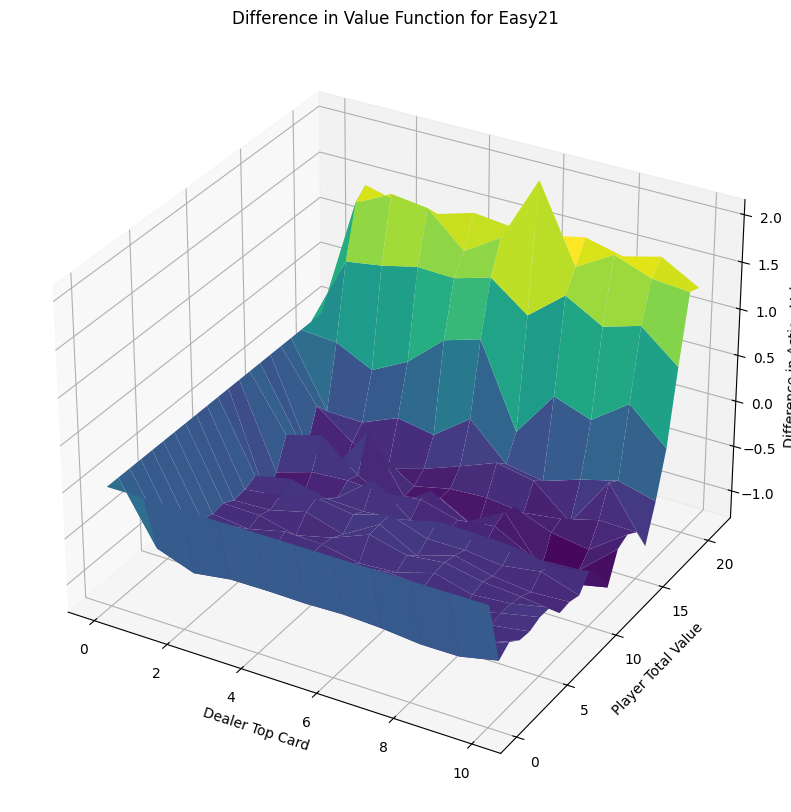

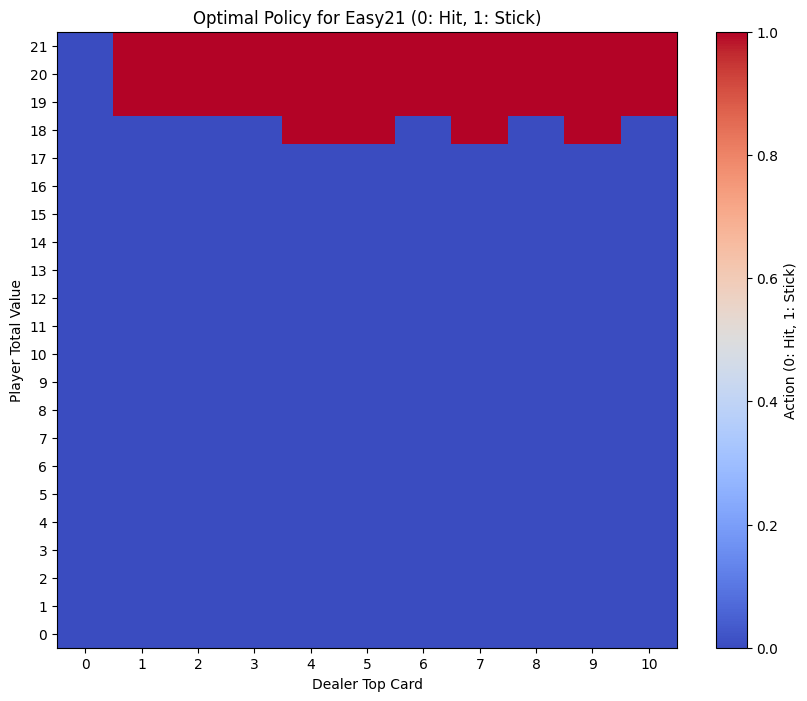

In [ ]:
plot_for_lambda(0.1, V)

#### Forward View

In [ ]:
V_forward = forward_view_sarsa_lambda()

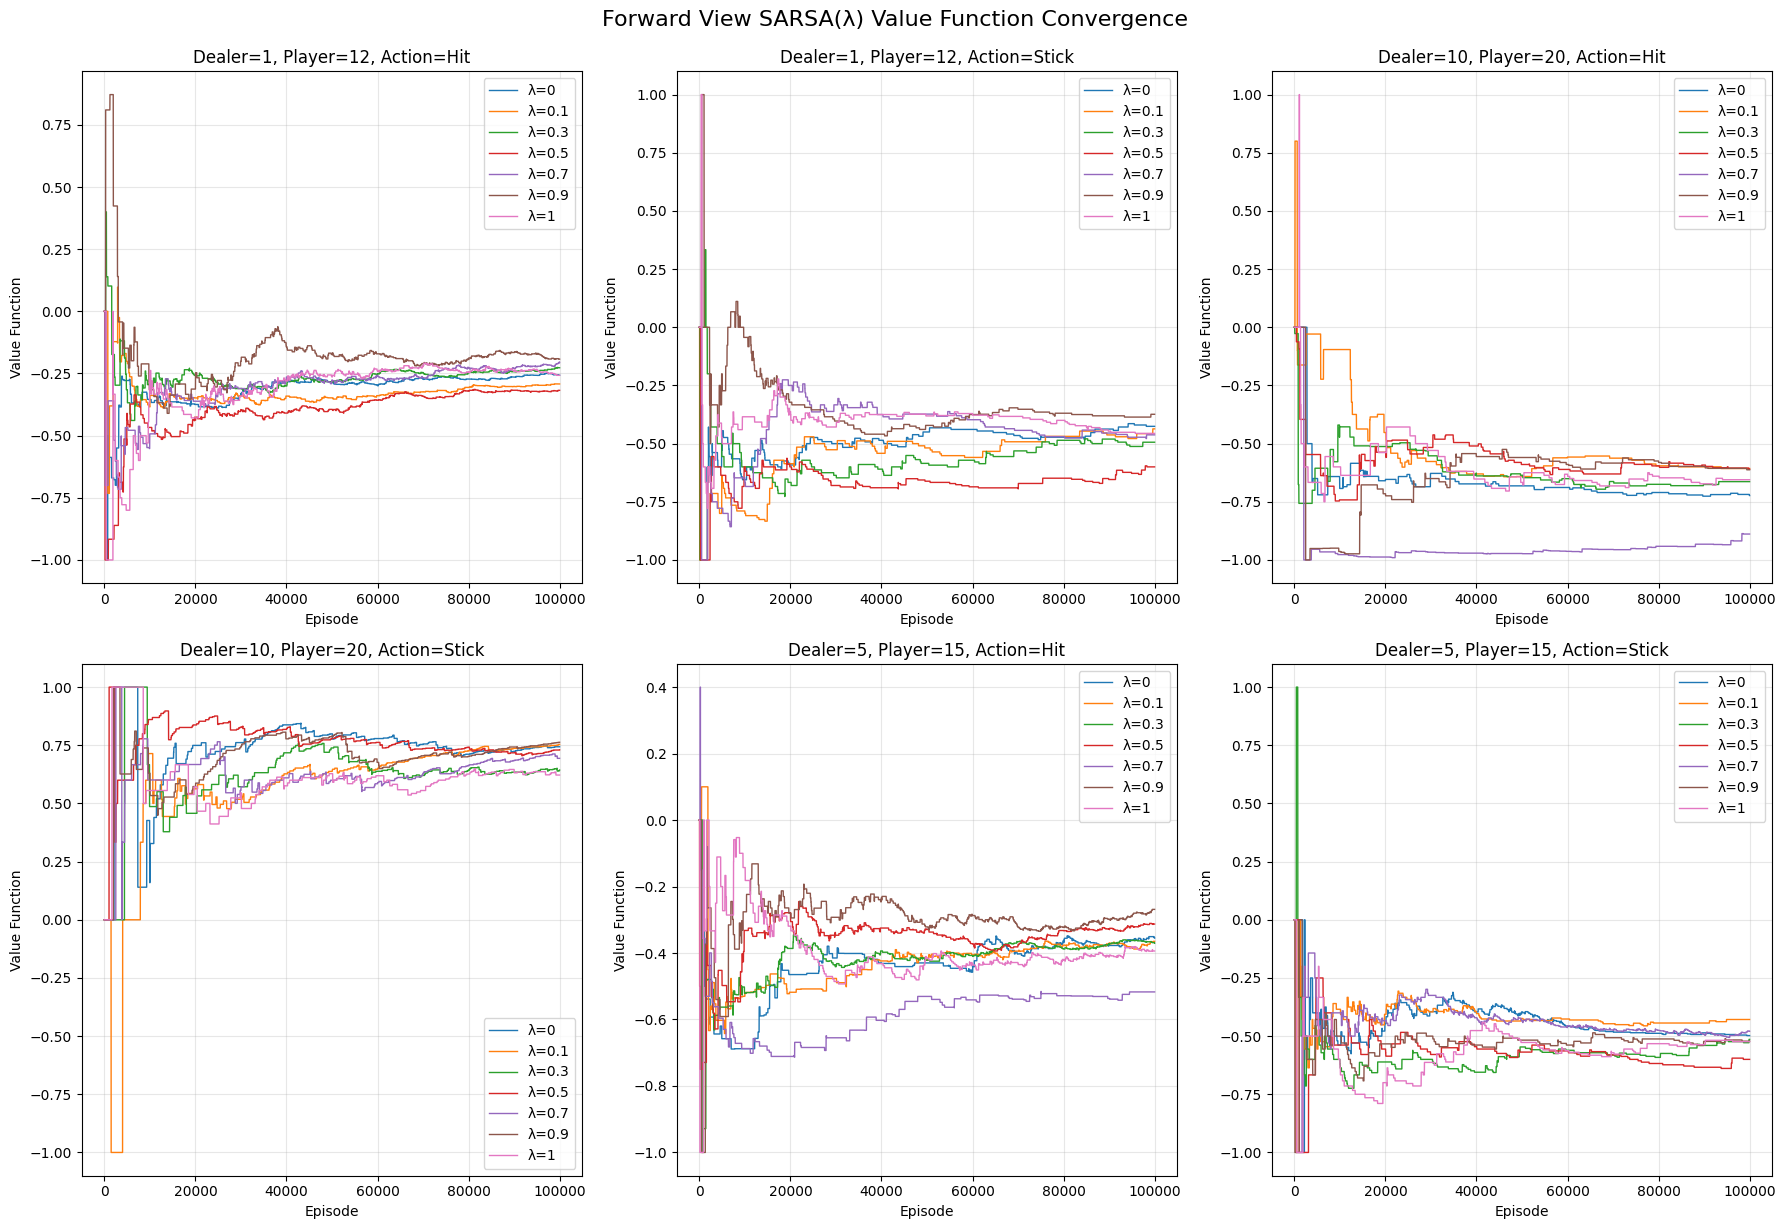

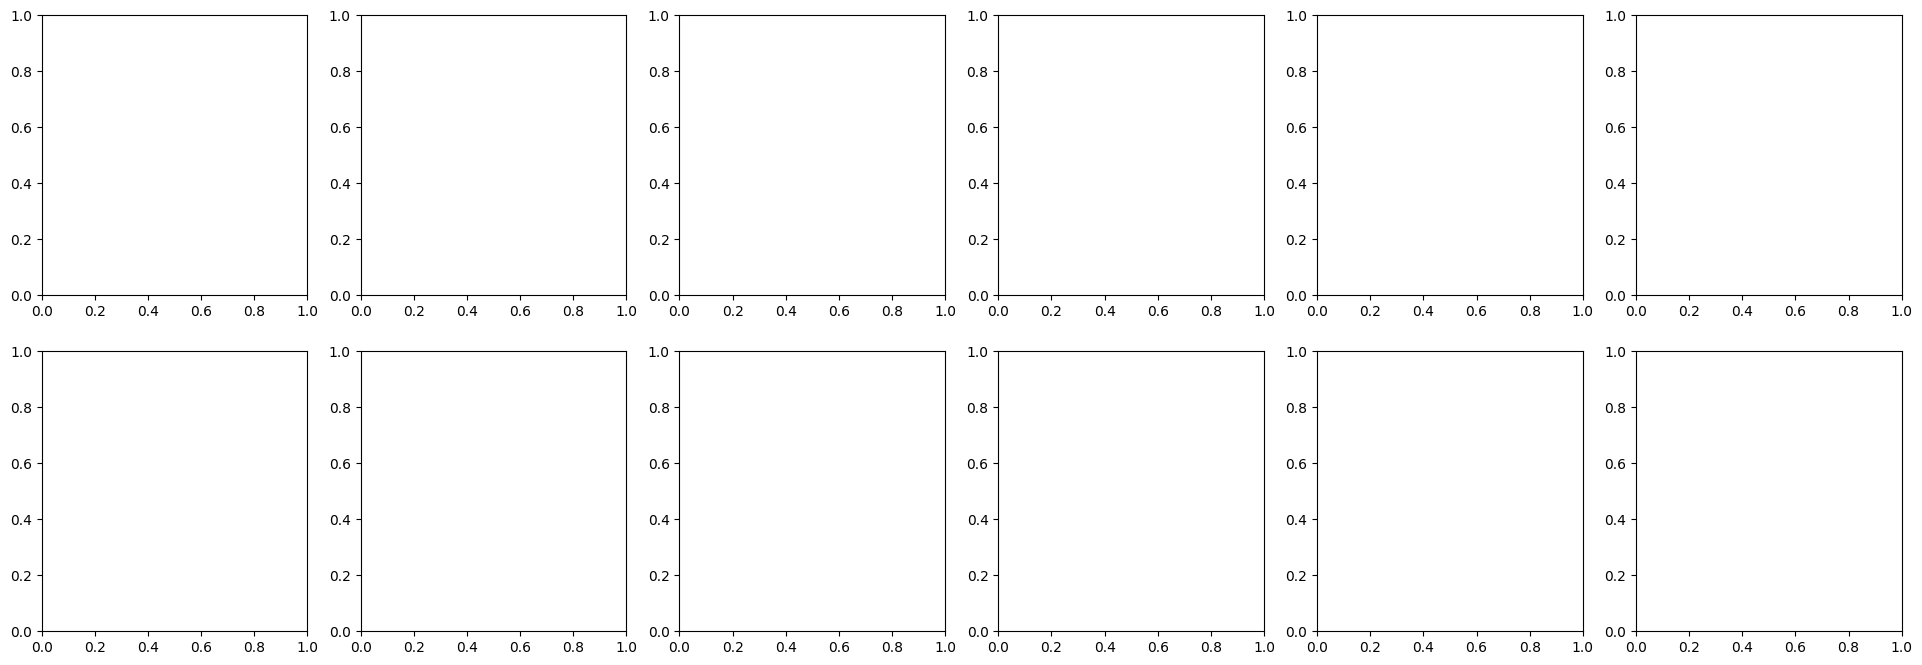

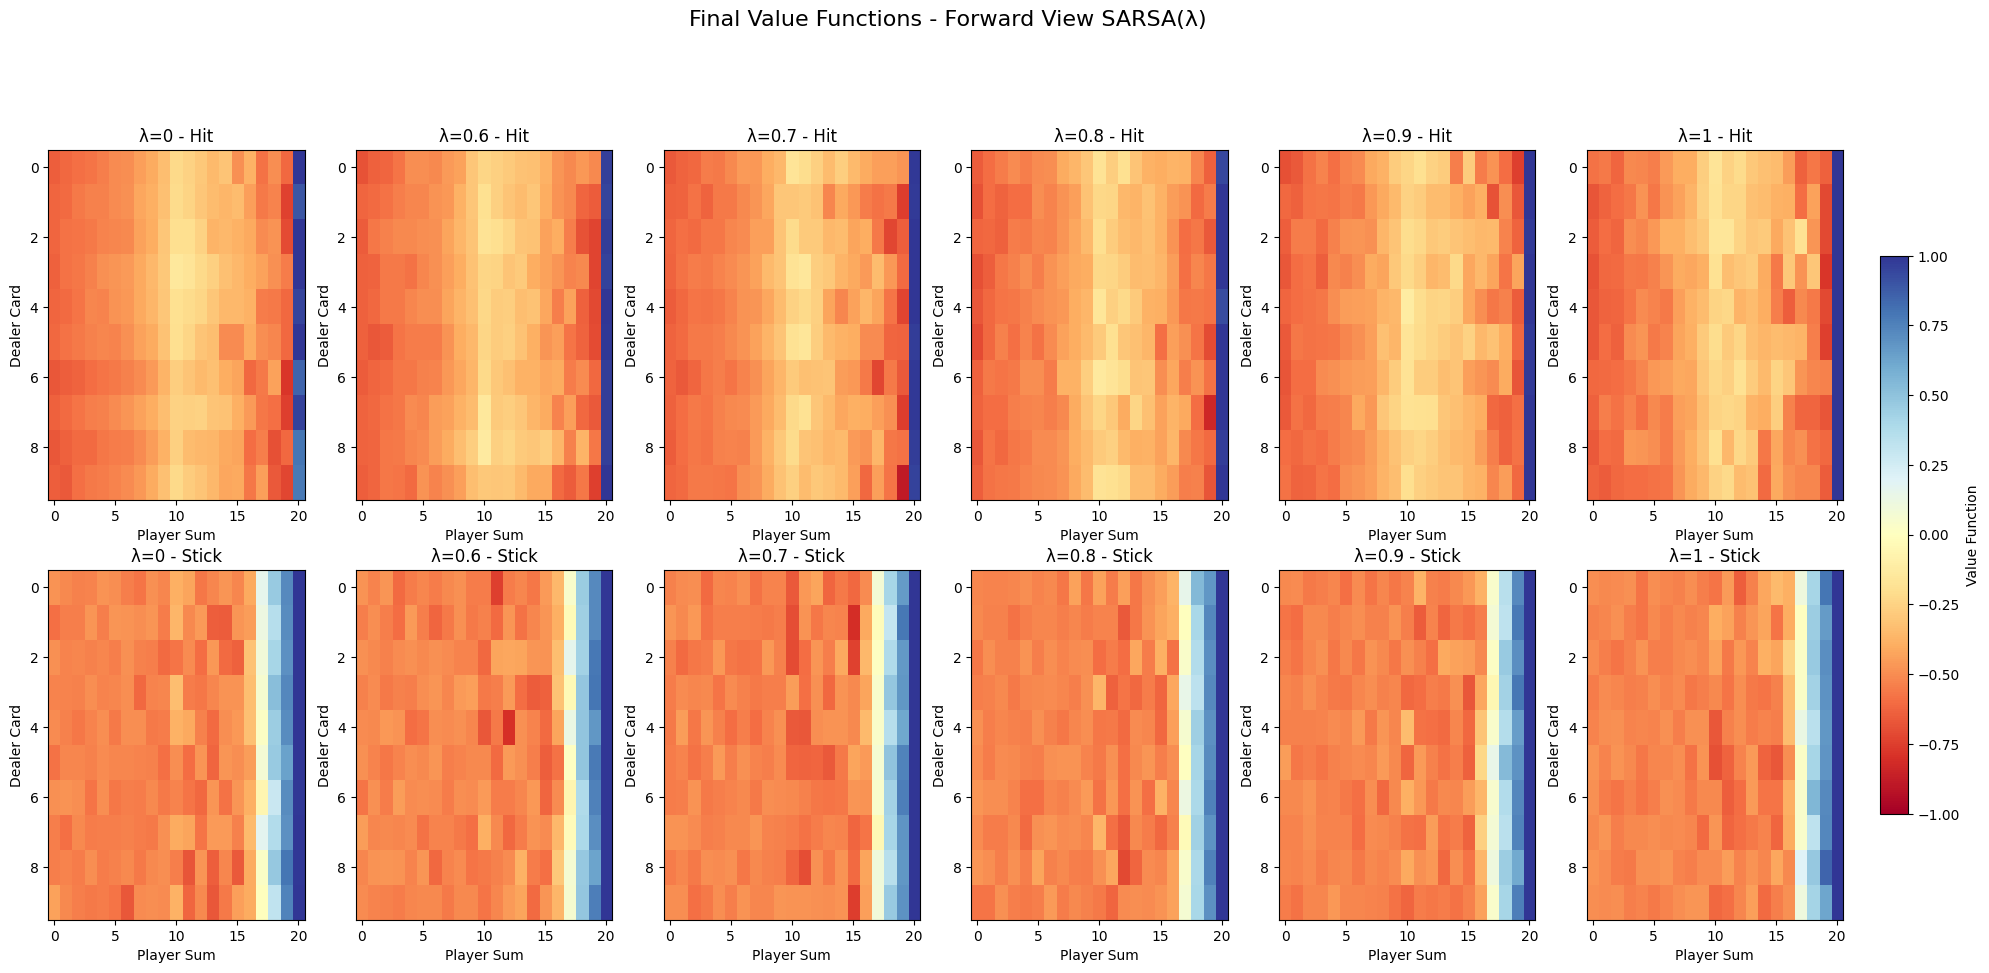

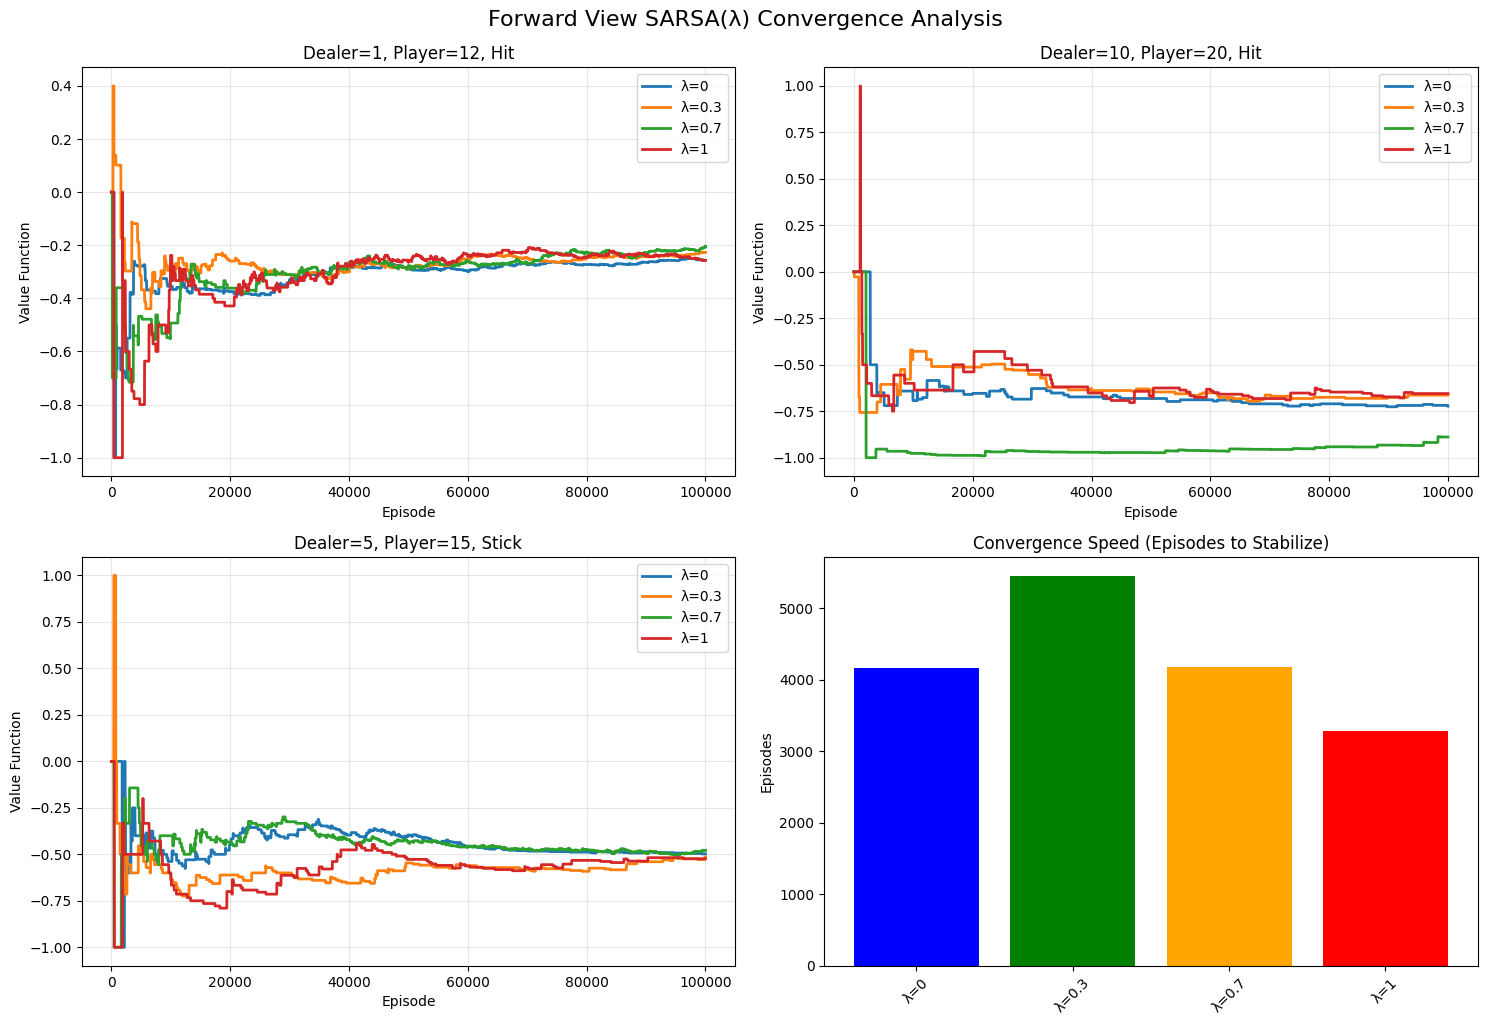


Convergence Analysis:
λ=0: Converged in ~4173 episodes
λ=0.3: Converged in ~5449 episodes
λ=0.7: Converged in ~4178 episodes
λ=1: Converged in ~3291 episodes


In [ ]:
states_to_track = [
    (1, 12, 0),   # dealer=1, player=12, stick
    (1, 12, 1),   # dealer=1, player=12, hit
    (10, 20, 0),  # dealer=10, player=20, stick
    (10, 20, 1),  # dealer=10, player=20, hit
    (5, 15, 0),   # dealer=5, player=15, stick
    (5, 15, 1),   # dealer=5, player=15, hit
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

for i, state in enumerate(states_to_track):
    dealer, player, action = state

    for lambda_idx, lambda_val in enumerate([0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]):
        if lambda_val in lambda_values:
            actual_lambda_idx = lambda_values.index(lambda_val)
            values = V_forward[dealer, player, action, actual_lambda_idx, :]
            axes[i].plot(values, label=f'λ={lambda_val}', linewidth=1)

    action_name = "Hit" if action == 0 else "Stick"
    axes[i].set_title(f'Dealer={dealer}, Player={player}, Action={action_name}')
    axes[i].set_xlabel('Episode')
    axes[i].set_ylabel('Value Function')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Forward View SARSA(λ) Value Function Convergence', y=1.02, fontsize=16)
plt.show()

fig, axes = plt.subplots(2, 6, figsize=(24, 8))

im1 = im2 = None

for lambda_idx, lambda_val in enumerate(lambda_values):
    row = lambda_idx // 6
    col = lambda_idx % 6

    if lambda_idx < 6:
        im1 = axes[0, col].imshow(V_forward[1:, 1:, 0, lambda_idx, -1], cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
        axes[0, col].set_title(f'λ={lambda_val} - Hit')
        axes[0, col].set_xlabel('Player Sum')
        axes[0, col].set_ylabel('Dealer Card')

        im2 = axes[1, col].imshow(V_forward[1:, 1:, 1, lambda_idx, -1], cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
        axes[1, col].set_title(f'λ={lambda_val} - Stick')
        axes[1, col].set_xlabel('Player Sum')
        axes[1, col].set_ylabel('Dealer Card')
    else:
        remaining_col = lambda_idx - 6
        if remaining_col < 5:
            im1 = axes[0, remaining_col + 1].imshow(V_forward[1:, 1:, 0, lambda_idx, -1], cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
            axes[0, remaining_col + 1].set_title(f'λ={lambda_val} - Hit')

            im2 = axes[1, remaining_col + 1].imshow(V_forward[1:, 1:, 1, lambda_idx, -1], cmap='RdYlBu', aspect='auto', vmin=-1, vmax=1)
            axes[1, remaining_col + 1].set_title(f'λ={lambda_val} - Stick')

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.015, pad=0.02)
cbar.set_label('Value Function')

plt.suptitle('Final Value Functions - Forward View SARSA(λ)', y=1.02, fontsize=16)
plt.show()

plt.figure(figsize=(15, 10))

comparison_states = [
    (1, 12, 0),
    (10, 20, 0),
    (5, 15, 1),
]

for i, state in enumerate(comparison_states):
    plt.subplot(2, 2, i+1)
    dealer, player, action = state

    for lambda_idx, lambda_val in enumerate([0, 0.3, 0.7, 1]):
        if lambda_val in lambda_values:
            actual_lambda_idx = lambda_values.index(lambda_val)
            values = V_forward[dealer, player, action, actual_lambda_idx, :]
            plt.plot(values, label=f'λ={lambda_val}', linewidth=2)

    action_name = "Hit" if action == 0 else "Stick"
    plt.title(f'Dealer={dealer}, Player={player}, {action_name}')
    plt.xlabel('Episode')
    plt.ylabel('Value Function')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
convergence_episodes = []
lambda_labels = []

for lambda_idx, lambda_val in enumerate([0, 0.3, 0.7, 1]):
    if lambda_val in lambda_values:
        actual_lambda_idx = lambda_values.index(lambda_val)
        state = (5, 15, 0)
        dealer, player, action = state
        values = V_forward[dealer, player, action, actual_lambda_idx, :]

        diffs = np.abs(np.diff(values))
        window_size = 1000
        for i in range(window_size, len(diffs)):
            recent_changes = diffs[i-window_size:i]
            if np.all(recent_changes < 0.001):
                convergence_episodes.append(i)
                lambda_labels.append(f'λ={lambda_val}')
                break
        else:
            convergence_episodes.append(len(diffs))
            lambda_labels.append(f'λ={lambda_val}')

plt.bar(lambda_labels, convergence_episodes, color=['blue', 'green', 'orange', 'red'])
plt.title('Convergence Speed (Episodes to Stabilize)')
plt.ylabel('Episodes')
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('Forward View SARSA(λ) Convergence Analysis', y=1.02, fontsize=16)
plt.show()

print("\nConvergence Analysis:")
for i, (lambda_val, episodes) in enumerate(zip([0, 0.3, 0.7, 1], convergence_episodes)):
    print(f"λ={lambda_val}: Converged in ~{episodes} episodes")

In [33]:
def plot_for_lambda_forward(l, V):
    l = int(l * 10)
    Z_0 = np.transpose(V[:, :, 0, l, number_of_episodes - 1])
    Z_1 = np.transpose(V[:, :, 1, l, number_of_episodes - 1])
    Z = np.maximum(Z_0, Z_1)
    Z_diff = Z_1 - Z_0
    optimal_policy = np.argmax(V[:, :, :, l, number_of_episodes - 1], axis=2)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
    ax.plot_surface(X, Y, Z_0, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Hit Action')
    ax.set_title('Value Function for Easy21 - Hit Action')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_1, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Stick Action')
    ax.set_title('Value Function for Easy21 - Stick Action')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Optimal Action')
    ax.set_title('Optimal Value Function for Easy21')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_diff, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Difference in Action Values')
    ax.set_title('Difference in Value Function for Easy21')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
    plt.colorbar(label='Action (0: Hit, 1: Stick)')
    plt.xlabel('Dealer Top Card')
    plt.ylabel('Player Total Value')
    plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
    plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
    plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
    plt.show()

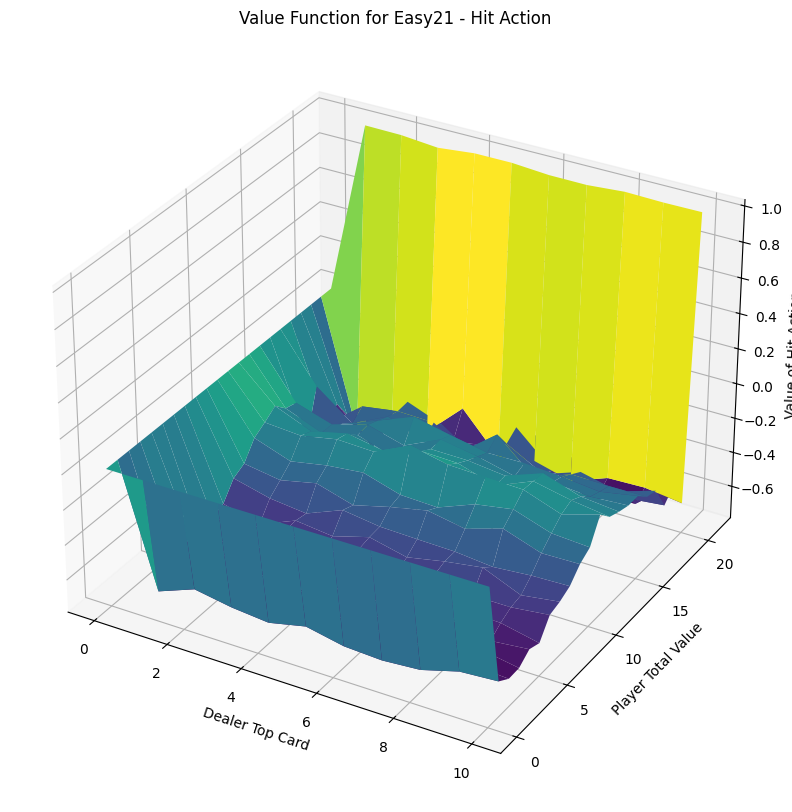

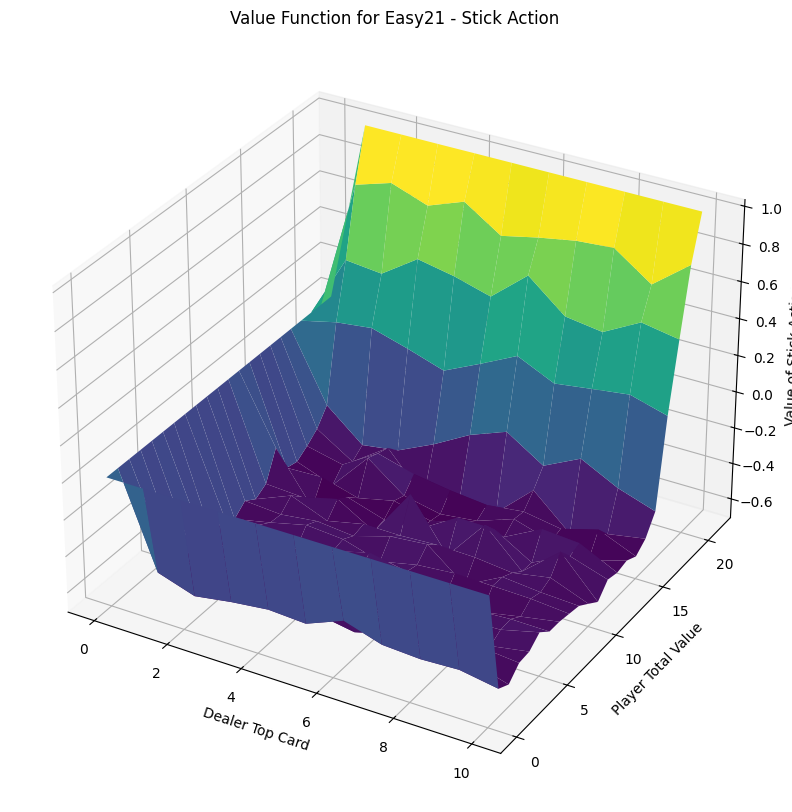

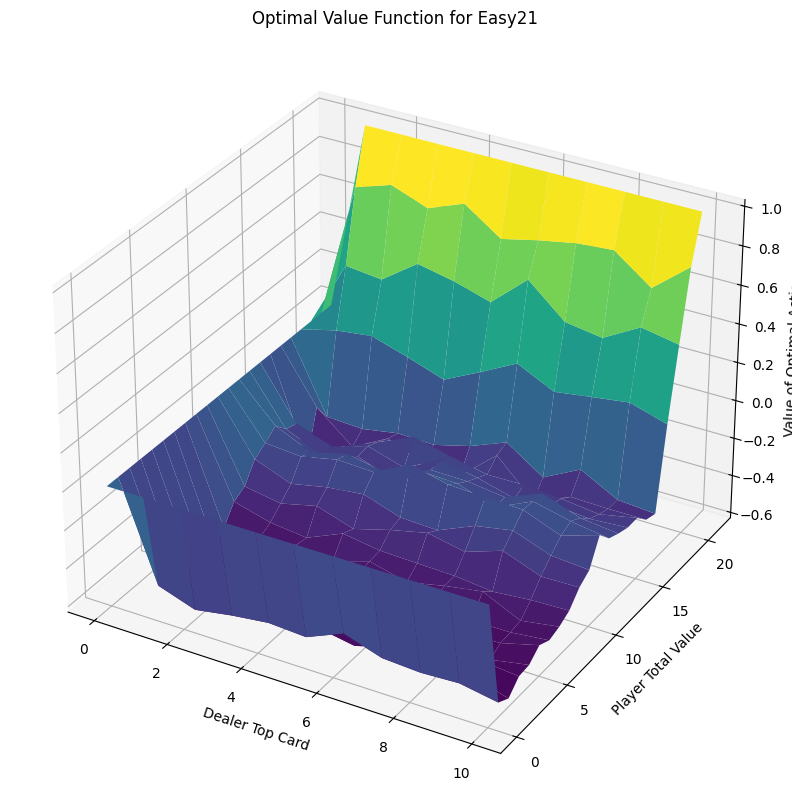

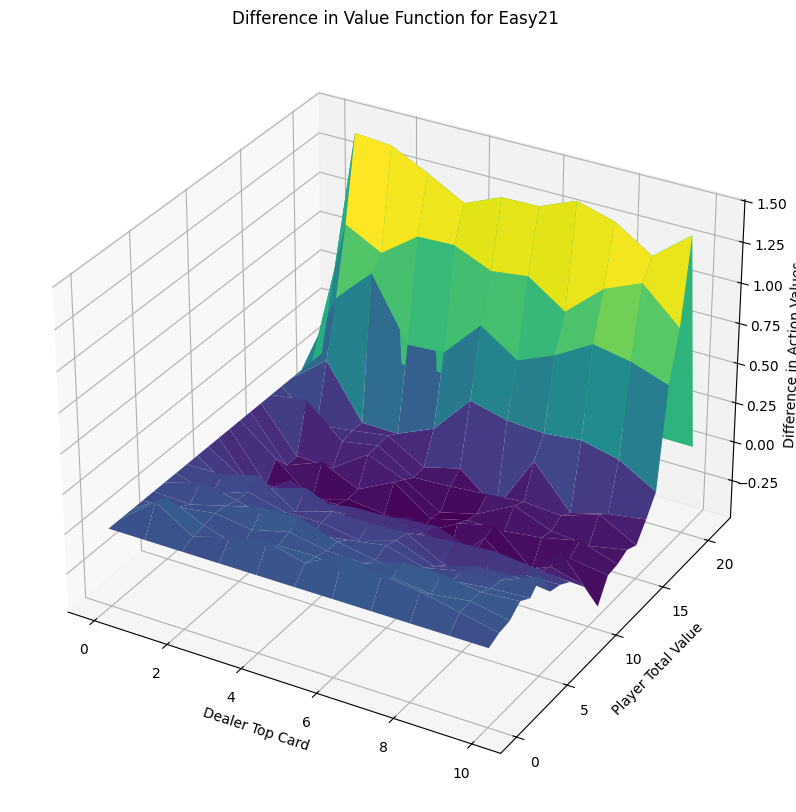

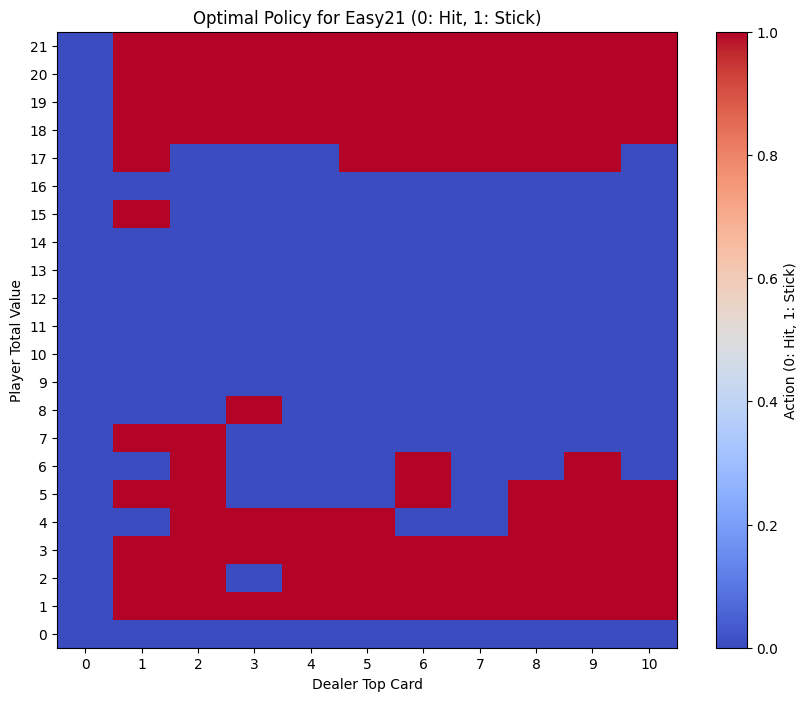

In [34]:
plot_for_lambda_forward(0.9, V_forward)